#**Details**
1. Macros used -> keep_hos
2. Output -> Std_data_2024Jul_analysis.csv

# **0 - Data and Measure Standardization_2024Jul.sas**

**Details**
1. Macros used -> keep_hos
2. Output -> Std_data_2024Jul_analysis.csv



In [2]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

# Define paths and variables
PATH1 = '/content/drive/My Drive/Capstone Project/SAS Star Data'
PATH2 = '/content/drive/My Drive/Capstone Project/SAS Star Data/Source Code/output'

year = "2024"
quarter = "Jul"

# Output file paths
MEASURE_MEAN = f"{PATH2}/Step 0 Out/measure_average_stddev_{year}{quarter}.csv"
MEASURE_ANALYSIS = f"{PATH2}/Step 0 Out/Std_data_{year}{quarter}_analysis.csv"
EXCLUDED_MEASURES = f"{PATH2}/Step 0 Out/less100_measure_{year}{quarter}.csv"
EXCLUDED_HOSPITALS = f"{PATH2}/Step 0 Out/excluded_hospitals_{year}{quarter}.csv"

# Load data
data = pd.read_csv(f"{PATH1}/Alldata_{year}{quarter}.csv")

# Define list of all measures
measure_all = [
    'MORT_30_AMI', 'MORT_30_CABG', 'MORT_30_COPD', 'MORT_30_HF', 'MORT_30_PN', 'MORT_30_STK', 'PSI_4_SURG_COMP',
    'COMP_HIP_KNEE', 'HAI_1', 'HAI_2', 'HAI_3', 'HAI_4', 'HAI_5', 'HAI_6', 'PSI_90_SAFETY',
    'EDAC_30_AMI', 'EDAC_30_HF', 'EDAC_30_PN', 'OP_32', 'READM_30_CABG', 'READM_30_COPD', 'READM_30_HIP_KNEE',
    'READM_30_HOSP_WIDE', 'OP_35_ADM', 'OP_35_ED', 'OP_36', 'H_COMP_1_STAR_RATING', 'H_COMP_2_STAR_RATING',
    'H_COMP_3_STAR_RATING', 'H_COMP_5_STAR_RATING', 'H_COMP_6_STAR_RATING', 'H_COMP_7_STAR_RATING',
    'H_GLOB_STAR_RATING', 'H_INDI_STAR_RATING', 'HCP_COVID_19', 'IMM_3', 'OP_10', 'OP_13', 'OP_18B', 'OP_2',
    'OP_22', 'OP_23', 'OP_29', 'OP_3B', 'OP_8', 'PC_01', 'SEP_1'
]

# Measures to flip based on the SAS "RE-DIRECT MEASURES" section
measures_to_flip = [
    'MORT_30_AMI', 'MORT_30_CABG', 'MORT_30_COPD', 'MORT_30_HF', 'MORT_30_PN', 'MORT_30_STK', 'PSI_4_SURG_COMP',
    'COMP_HIP_KNEE', 'HAI_1', 'HAI_2', 'HAI_3', 'HAI_4', 'HAI_5', 'HAI_6', 'PSI_90_SAFETY',
    'EDAC_30_AMI', 'EDAC_30_HF', 'EDAC_30_PN', 'OP_32', 'READM_30_CABG', 'READM_30_COPD', 'READM_30_HIP_KNEE',
    'READM_30_HOSP_WIDE', 'OP_35_ADM', 'OP_35_ED', 'OP_36', 'OP_22', 'PC_01', 'OP_3B', 'OP_18B', 'OP_8', 'OP_10', 'OP_13'
]

# Filter measures based on data availability
measure_all = [col for col in measure_all if col in data.columns]
measure_volume = data[measure_all].notna().sum()
measure_exclude = measure_volume[measure_volume <= 100].index.tolist()
included_measures = [measure for measure in measure_all if measure not in measure_exclude]

# Save excluded measures and their frequencies
excluded_measures_df = pd.DataFrame({
    'excluded_measure': measure_exclude,
    'frequency': measure_volume[measure_exclude].values
})
excluded_measures_df.to_csv(EXCLUDED_MEASURES, index=False)

# Calculate `Total_m_cnt` for each hospital as the count of non-missing values in **all measures**
data['Total_m_cnt'] = data[measure_all].notna().sum(axis=1)

# Identify hospitals with no valid data in any of the `measure_all` columns
excluded_hospitals = data[data['Total_m_cnt'] < 1]
excluded_hospitals.to_csv(EXCLUDED_HOSPITALS, index=False)

# Filter out hospitals with `Total_m_cnt < 1`
data = data[data['Total_m_cnt'] >= 1]

# Remove `Total_m_cnt` after filtering as it's no longer needed
data = data.drop(columns=['Total_m_cnt'])

# Calculate statistics for `measure_average_stddev`
measure_stats = {
    '_TYPE_': [0, 0, 0, 0, 0],
    '_FREQ_': [len(data)] * 5,
    '_STAT_': ['N', 'MIN', 'MAX', 'MEAN', 'STD']
}

for measure in included_measures:
    stats = [
        data[measure].count(),
        data[measure].min(),
        data[measure].max(),
        data[measure].mean(),
        data[measure].std()
    ]
    measure_stats[measure] = stats

# Create DataFrame for measure statistics and save
measure_stats_df = pd.DataFrame(measure_stats)
measure_stats_df.to_csv(MEASURE_MEAN, index=False)

# Standardize included measures
std_data = (data[included_measures] - data[included_measures].mean()) / data[included_measures].std()

# Flip the measures as specified
std_data[measures_to_flip] = std_data[measures_to_flip] * -1

# Rename columns to include "std_" prefix
std_data.columns = [f"std_{col}" for col in std_data.columns]

# Combine standardized data with PROVIDER_ID and denominators
final_output = pd.concat([data[['PROVIDER_ID']], std_data, data[[f"{col}_DEN" for col in included_measures if f"{col}_DEN" in data.columns]]], axis=1)

# Save the final standardized data for analysis
final_output.to_csv(MEASURE_ANALYSIS, index=False)

print("Processing completed. Files saved:")
print(" - Measure Mean/StdDev:", MEASURE_MEAN)
print(" - Excluded Measures Data with Frequency:", EXCLUDED_MEASURES)
print(" - Excluded Hospitals Data (no valid data in any measure):", EXCLUDED_HOSPITALS)
print(" - Final Standardized Data for Analysis:", MEASURE_ANALYSIS)


Processing completed. Files saved:
 - Measure Mean/StdDev: /content/drive/My Drive/Capstone Project/SAS Star Data/Source Code/output/Step 0 Out/measure_average_stddev_2024Jul.csv
 - Excluded Measures Data with Frequency: /content/drive/My Drive/Capstone Project/SAS Star Data/Source Code/output/Step 0 Out/less100_measure_2024Jul.csv
 - Excluded Hospitals Data (no valid data in any measure): /content/drive/My Drive/Capstone Project/SAS Star Data/Source Code/output/Step 0 Out/excluded_hospitals_2024Jul.csv
 - Final Standardized Data for Analysis: /content/drive/My Drive/Capstone Project/SAS Star Data/Source Code/output/Step 0 Out/Std_data_2024Jul_analysis.csv


In [ ]:
print(measure_volume)

In [ ]:
print(measure_exclude)

['OP_2']


# **1 - First stage_Simple Average of Measure Scores_2024Jul:**

**Details**
1. Macros used -> grp_scores
2. Output -> Std_data_2024Jul_analysis.csv

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import zscore

# Paths and settings
PATH2 = '/content/drive/My Drive/Capstone Project/SAS Star Data/Source Code/output'
MEASURE_ANALYSIS = f"{PATH2}/Step 0 Out/Std_data_2024Jul_analysis.csv"

# Load the standardized data for each measure
data = pd.read_csv(MEASURE_ANALYSIS)

# Measure groups (with "std_" prefix already applied)
measure_OM = ['std_MORT_30_AMI', 'std_MORT_30_CABG', 'std_MORT_30_COPD', 'std_MORT_30_HF', 'std_MORT_30_PN', 'std_MORT_30_STK', 'std_PSI_4_SURG_COMP']
measure_OS = ['std_COMP_HIP_KNEE', 'std_HAI_1', 'std_HAI_2', 'std_HAI_3', 'std_HAI_4', 'std_HAI_5', 'std_HAI_6', 'std_PSI_90_SAFETY']
measure_OR = ['std_EDAC_30_AMI', 'std_EDAC_30_HF', 'std_EDAC_30_PN', 'std_OP_32', 'std_READM_30_CABG', 'std_READM_30_COPD', 'std_READM_30_HIP_KNEE', 'std_READM_30_HOSP_WIDE', 'std_OP_35_ADM', 'std_OP_35_ED', 'std_OP_36']
measure_PtExp = ['std_H_COMP_1_STAR_RATING', 'std_H_COMP_2_STAR_RATING', 'std_H_COMP_3_STAR_RATING', 'std_H_COMP_5_STAR_RATING', 'std_H_COMP_6_STAR_RATING', 'std_H_COMP_7_STAR_RATING', 'std_H_GLOB_STAR_RATING', 'std_H_INDI_STAR_RATING']
measure_Process = ['std_HCP_COVID_19', 'std_IMM_3', 'std_OP_10', 'std_OP_13', 'std_OP_18B', 'std_OP_22', 'std_OP_23', 'std_OP_29', 'std_OP_3B', 'std_OP_8', 'std_PC_01', 'std_SEP_1']

# Function to calculate group scores for a measure group
def calculate_group_score(df, measure_columns):
    # Count non-missing values in the measure columns
    total_cnt = df[measure_columns].notna().sum(axis=1)

    # Calculate the average score across non-missing measures
    avg = df[measure_columns].mean(axis=1)

    # Calculate mean and standard deviation of the average scores (for group stats)
    group_mean = avg.mean()
    group_std = avg.std()

    # Standardize the average score to get the group score
    grp_score = (avg - group_mean) / group_std

    # Create a DataFrame to return with relevant columns
    group_score_df = pd.DataFrame({
        'PROVIDER_ID': df['PROVIDER_ID'],
        'total_cnt': total_cnt,
        'measure_wt': 1 / total_cnt.replace(0, np.nan),  # Avoid division by zero
        'score_before_std': avg,
        'Mean': group_mean,
        'StdDev': group_std,
        'grp_score': grp_score
    })

    return group_score_df

# Calculate and save group scores for each measure group
# Define output path for "Step 1 Out" directory
STEP_1_OUT_PATH = f"{PATH2}/Step 1 Out"

# Mortality Group
mortality_group_scores = calculate_group_score(data, measure_OM)
mortality_group_scores.to_csv(f"{STEP_1_OUT_PATH}/Outcome_mortality.csv", index=False)

# Safety of Care Group
safety_group_scores = calculate_group_score(data, measure_OS)
safety_group_scores.to_csv(f"{STEP_1_OUT_PATH}/Outcome_safety.csv", index=False)

# Readmission Group
readmission_group_scores = calculate_group_score(data, measure_OR)
readmission_group_scores.to_csv(f"{STEP_1_OUT_PATH}/Outcome_readmission.csv", index=False)

# Patient Experience Group
pt_exp_group_scores = calculate_group_score(data, measure_PtExp)
pt_exp_group_scores.to_csv(f"{STEP_1_OUT_PATH}/PtExp.csv", index=False)

# Timely and Effective Care Group
process_group_scores = calculate_group_score(data, measure_Process)
process_group_scores.to_csv(f"{STEP_1_OUT_PATH}/Process.csv", index=False)

print("Group score calculation completed. Files saved for each measure group.")


Group score calculation completed. Files saved for each measure group.


In [ ]:
print(data.columns)

Index(['PROVIDER_ID', 'std_MORT_30_AMI', 'std_MORT_30_CABG',
       'std_MORT_30_COPD', 'std_MORT_30_HF', 'std_MORT_30_PN',
       'std_MORT_30_STK', 'std_PSI_4_SURG_COMP', 'std_COMP_HIP_KNEE',
       'std_HAI_1', 'std_HAI_2', 'std_HAI_3', 'std_HAI_4', 'std_HAI_5',
       'std_HAI_6', 'std_PSI_90_SAFETY', 'std_EDAC_30_AMI', 'std_EDAC_30_HF',
       'std_EDAC_30_PN', 'std_OP_32', 'std_READM_30_CABG', 'std_READM_30_COPD',
       'std_READM_30_HIP_KNEE', 'std_READM_30_HOSP_WIDE', 'std_OP_35_ADM',
       'std_OP_35_ED', 'std_OP_36', 'std_H_COMP_1_STAR_RATING',
       'std_H_COMP_2_STAR_RATING', 'std_H_COMP_3_STAR_RATING',
       'std_H_COMP_5_STAR_RATING', 'std_H_COMP_6_STAR_RATING',
       'std_H_COMP_7_STAR_RATING', 'std_H_GLOB_STAR_RATING',
       'std_H_INDI_STAR_RATING', 'std_HCP_COVID_19', 'std_IMM_3', 'std_OP_10',
       'std_OP_13', 'std_OP_22', 'std_OP_23', 'std_OP_29', 'std_OP_8',
       'std_PC_01', 'std_SEP_1'],
      dtype='object')


# **2 - Second Stage_Weighted Average and Categorize Star_2024Jul.sas**

K means in a single dimension - stochastic element may not be replicable
Which K-mean variant do they use in sas - which ones work in Python?

One of the columns in the hospital data does have the star rating -Another source of truth

SAS methodology - Small hospitals include 3, large hospitals include 5 - gamification happening here

3, 4, 5 grouping by cut points


Business value questions

- Who benefits most by supressing certain data
- geographical benefits


Previous algorithm lacked interpretability - ML


which hospitals are changing the fastest is what is being measured


Some more notes on the functionality:

# **Quintile Medians are Calculated Per Peer Group**

For example:
- In Peer Group 1, calculate quintiles for hospitals with 3 valid measure groups.
- In Peer Group 2, calculate quintiles for hospitals with 4 valid measure groups.


This ensures that the starting centroids for clustering are tailored to each group’s specific performance distribution.







In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from scipy.stats import mstats, zscore

##### Merge Files ######################################################################################################################

# Paths to group score CSV files
STEP_1_OUT_PATH = '/content/drive/My Drive/Capstone Project/SAS Star Data/Source Code/output/Step 1 Out'
STEP_2_OUT_PATH = '/content/drive/My Drive/Capstone Project/SAS Star Data/Source Code/output/Step 2 Out'

# Load group scores
mortality_scores = pd.read_csv(f"{STEP_1_OUT_PATH}/Outcome_mortality.csv").rename(columns={"grp_score": "Std_Outcomes_Mortality_score"})
readmission_scores = pd.read_csv(f"{STEP_1_OUT_PATH}/Outcome_readmission.csv").rename(columns={"grp_score": "Std_Outcomes_Readmission_score"})
safety_scores = pd.read_csv(f"{STEP_1_OUT_PATH}/Outcome_safety.csv").rename(columns={"grp_score": "Std_Outcomes_Safety_score"})
pt_exp_scores = pd.read_csv(f"{STEP_1_OUT_PATH}/PtExp.csv").rename(columns={"grp_score": "Std_PatientExp_score"})
process_scores = pd.read_csv(f"{STEP_1_OUT_PATH}/Process.csv").rename(columns={"grp_score": "Std_Process_score"})

# Merge all group scores into one DataFrame
all_scores = mortality_scores.merge(
    readmission_scores[['PROVIDER_ID', 'Std_Outcomes_Readmission_score']],
    on='PROVIDER_ID', how='outer'
).merge(
    safety_scores[['PROVIDER_ID', 'Std_Outcomes_Safety_score']],
    on='PROVIDER_ID', how='outer'
).merge(
    pt_exp_scores[['PROVIDER_ID', 'Std_PatientExp_score']],
    on='PROVIDER_ID', how='outer'
).merge(
    process_scores[['PROVIDER_ID', 'Std_Process_score']],
    on='PROVIDER_ID', how='outer'
)

# Save the merged data to the "Step 2 Out" directory
merged_output_path = f"{STEP_2_OUT_PATH}/All_Group_Scores.csv"
all_scores.to_csv(merged_output_path, index=False)

print(f"Group scores merged successfully. File saved at: {merged_output_path}")

##### Summary Score ######################################################################################################################

# Load the merged data
merged_file_path = f"{STEP_2_OUT_PATH}/All_Group_Scores.csv"
data = pd.read_csv(merged_file_path)

# Fixed standard weights from CMS
weights = {
    "Std_PatientExp_score": 0.22,
    "Std_Outcomes_Readmission_score": 0.22,
    "Std_Outcomes_Mortality_score": 0.22,
    "Std_Outcomes_Safety_score": 0.22,
    "Std_Process_score": 0.12
}

# Add weights to DataFrame
for group, weight in weights.items():
    data[f"std_weight_{group}"] = weight

# Indicator for missing group scores
for group in weights.keys():
    data[f"I_{group}"] = data[group].isna().astype(int)

# Redistribute weights
for group in weights.keys():
    redistribution_factor = 1 - sum(data[f"I_{col}"] * weights[col] for col in weights.keys())
    data[f"weight_{group}"] = np.where(
        data[f"I_{group}"] == 1,
        np.nan,  # Keep missing if group is missing
        data[f"std_weight_{group}"] / redistribution_factor
    )

# Calculate weighted scores
for group in weights.keys():
    data[f"sum_weight_ave_{group}"] = data[f"weight_{group}"] * data[group]

# Calculate the final summary score
weighted_cols = [f"sum_weight_ave_{group}" for group in weights.keys()]
data["summary_score"] = data[weighted_cols].sum(axis=1)

# Save the resulting summary scores to a new CSV file
summary_output_path = f"{STEP_2_OUT_PATH}/Summary_Scores.csv"
data.to_csv(summary_output_path, index=False)

print(f"Summary scores calculated successfully. File saved at: {summary_output_path}")

##### Reporting >3 Measures #############################################################################################################

MEASURE_ANALYSIS = "/content/drive/My Drive/Capstone Project/SAS Star Data/Source Code/output/Step 0 Out/Std_data_2024Jul_analysis.csv"
REPORT_OUTPUT_PATH = "/content/drive/My Drive/Capstone Project/SAS Star Data/Source Code/output/Step 2 Out/Report_Indicator.csv"

# Load the standardized data
data = pd.read_csv(MEASURE_ANALYSIS)

# Define groups with correct column names
measure_OM = ['std_MORT_30_AMI', 'std_MORT_30_CABG', 'std_MORT_30_COPD', 'std_MORT_30_HF',
              'std_MORT_30_PN', 'std_MORT_30_STK', 'std_PSI_4_SURG_COMP']
measure_OS = ['std_COMP_HIP_KNEE', 'std_HAI_1', 'std_HAI_2', 'std_HAI_3', 'std_HAI_4',
              'std_HAI_5', 'std_HAI_6', 'std_PSI_90_SAFETY']
measure_OR = ['std_EDAC_30_AMI', 'std_EDAC_30_HF', 'std_EDAC_30_PN', 'std_OP_32',
              'std_READM_30_CABG', 'std_READM_30_COPD', 'std_READM_30_HIP_KNEE',
              'std_READM_30_HOSP_WIDE', 'std_OP_35_ADM', 'std_OP_35_ED', 'std_OP_36']
measure_PtExp = ['std_H_COMP_1_STAR_RATING', 'std_H_COMP_2_STAR_RATING', 'std_H_COMP_3_STAR_RATING',
                 'std_H_COMP_5_STAR_RATING', 'std_H_COMP_6_STAR_RATING', 'std_H_COMP_7_STAR_RATING',
                 'std_H_GLOB_STAR_RATING', 'std_H_INDI_STAR_RATING']
measure_Process = ['std_HCP_COVID_19', 'std_IMM_3', 'std_OP_10', 'std_OP_13', 'std_OP_18B',
                   'std_OP_22', 'std_OP_23', 'std_OP_29', 'std_OP_3B', 'std_OP_8', 'std_PC_01', 'std_SEP_1']

# Count measures for each group
data['Outcomes_Mortality_cnt'] = data[measure_OM].notnull().sum(axis=1)
data['Outcomes_Safety_cnt'] = data[measure_OS].notnull().sum(axis=1)
data['Outcomes_Readmission_cnt'] = data[measure_OR].notnull().sum(axis=1)
data['Patient_Experience_cnt'] = data[measure_PtExp].notnull().sum(axis=1)
data['Process_cnt'] = data[measure_Process].notnull().sum(axis=1)

# Calculate Total Measure Group Count
data['Total_measure_group_cnt'] = (
    (data['Outcomes_Mortality_cnt'] >= 3).astype(int) +
    (data['Outcomes_Safety_cnt'] >= 3).astype(int) +
    (data['Outcomes_Readmission_cnt'] >= 3).astype(int) +
    (data['Patient_Experience_cnt'] >= 3).astype(int) +
    (data['Process_cnt'] >= 3).astype(int)
)

# Calculate MortSafe Group Count
data['MortSafe_Group_cnt'] = (
    (data['Outcomes_Mortality_cnt'] >= 3).astype(int) +
    (data['Outcomes_Safety_cnt'] >= 3).astype(int)
)

# Determine Reporting Indicator
data['report_indicator'] = (
    (data['MortSafe_Group_cnt'] >= 1) & (data['Total_measure_group_cnt'] >= 3)
).astype(int)

# Assign Peer Grouping
def assign_peer_group(row):
    if row['Total_measure_group_cnt'] == 3:
        return '1) # of groups=3'
    elif row['Total_measure_group_cnt'] == 4:
        return '2) # of groups=4'
    elif row['Total_measure_group_cnt'] == 5:
        return '3) # of groups=5'
    return None

data['cnt_grp'] = data.apply(assign_peer_group, axis=1)

# Save the Report Indicator Output
data[['PROVIDER_ID', 'report_indicator', 'Patient_Experience_cnt', 'Outcomes_Readmission_cnt',
      'Outcomes_Mortality_cnt', 'Outcomes_Safety_cnt', 'Process_cnt',
      'Total_measure_group_cnt', 'MortSafe_Group_cnt', 'cnt_grp']].to_csv(REPORT_OUTPUT_PATH, index=False)

print(f"Report indicator and grouping saved to {REPORT_OUTPUT_PATH}")

##### K-means Clustering ##############################################################################################################

# Load the report macro results
data = pd.read_csv(REPORT_OUTPUT_PATH)
summary_scores = pd.read_csv(summary_output_path)

# Merge `summary_score` into `data`
if 'summary_score' not in data.columns:
    data = data.merge(summary_scores[['PROVIDER_ID', 'summary_score']], on='PROVIDER_ID', how='left')

# Function to perform K-means clustering
def kmeans_clustering(data, peer_group, n_clusters=5):
    group_data = data[(data['cnt_grp'] == peer_group) & (data['report_indicator'] == 1)].copy()
    if group_data.empty:
        return pd.DataFrame()
    quintiles = np.percentile(group_data['summary_score'], [20, 40, 60, 80])
    quintile_medians = [
        group_data[group_data['summary_score'] <= quintiles[0]]['summary_score'].median(),
        group_data[(group_data['summary_score'] > quintiles[0]) & (group_data['summary_score'] <= quintiles[1])]['summary_score'].median(),
        group_data[(group_data['summary_score'] > quintiles[1]) & (group_data['summary_score'] <= quintiles[2])]['summary_score'].median(),
        group_data[(group_data['summary_score'] > quintiles[2]) & (group_data['summary_score'] <= quintiles[3])]['summary_score'].median(),
        group_data[group_data['summary_score'] > quintiles[3]]['summary_score'].median()
    ]
    initial_centers = np.array([m for m in quintile_medians if not np.isnan(m)]).reshape(-1, 1)
    kmeans_phase1 = KMeans(n_clusters=n_clusters, init=initial_centers, n_init=1, max_iter=1000, random_state=42)
    group_data['cluster'] = kmeans_phase1.fit_predict(group_data[['summary_score']])
    group_data = group_data[np.abs(zscore(group_data['summary_score'])) < 3]
    kmeans_phase2 = KMeans(n_clusters=n_clusters, init=kmeans_phase1.cluster_centers_, n_init=1, max_iter=1000, random_state=42)
    group_data['cluster'] = kmeans_phase2.fit_predict(group_data[['summary_score']])
    cluster_means = group_data.groupby('cluster')['summary_score'].mean().sort_values()
    cluster_to_star = {cluster: star for star, cluster in enumerate(cluster_means.index, start=1)}
    group_data['star'] = group_data['cluster'].map(cluster_to_star)
    return group_data[['PROVIDER_ID', 'star', 'cnt_grp']]

# Apply K-means to each peer group
peer_groups = data['cnt_grp'].unique()
all_clusters = []
for peer_group in peer_groups:
    clustered_data = kmeans_clustering(data, peer_group)
    if not clustered_data.empty:
        all_clusters.append(clustered_data)

# Combine results for all peer groups
all_clusters_df = pd.concat(all_clusters, ignore_index=True)
data = data.merge(all_clusters_df, on=['PROVIDER_ID', 'cnt_grp'], how='left')
data['star'] = np.where(data['report_indicator'] == 0, "N/A", data['star'])

# Save final results
final_output_path = "/content/drive/My Drive/Capstone Project/SAS Star Data/Source Code/output/Step 2 Out/Star_Ratings.csv"
data.to_csv(final_output_path, index=False)
print(f"K-means clustering and star ratings completed. Results saved to {final_output_path}.")


Group scores merged successfully. File saved at: /content/drive/My Drive/Capstone Project/SAS Star Data/Source Code/output/Step 2 Out/All_Group_Scores.csv
Summary scores calculated successfully. File saved at: /content/drive/My Drive/Capstone Project/SAS Star Data/Source Code/output/Step 2 Out/Summary_Scores.csv
Report indicator and grouping saved to /content/drive/My Drive/Capstone Project/SAS Star Data/Source Code/output/Step 2 Out/Report_Indicator.csv
K-means clustering and star ratings completed. Results saved to /content/drive/My Drive/Capstone Project/SAS Star Data/Source Code/output/Step 2 Out/Star_Ratings.csv.


# Two more outputs -> Add Hospital info + Filter for riverside + measure groups

In [ ]:
import pandas as pd

# CCNs for the four Riverside hospitals
riverside_ccns = ["490143", "490052", "490037", "490130"]  # Ensure CCNs are strings

# Paths to the datasets
hgi_clean_path = "/content/drive/My Drive/Capstone Project/Hospitals Data/Cleaned CSV/HGI_Clean.csv"
star_ratings_input_path = "/content/drive/My Drive/Capstone Project/SAS Star Data/Source Code/output/Step 2 Out/Star_Ratings.csv"
star_ratings_output_path = "/content/drive/My Drive/Capstone Project/SAS Star Data/Source Code/output/Step 2 Out/star_ratings_all_labeled.csv"
summary_score_file = "/content/drive/My Drive/Capstone Project/SAS Star Data/Source Code/output/Step 2 Out/Summary_Scores.csv"

# Load the HGI_Clean file
hgi_clean = pd.read_csv(hgi_clean_path)
hgi_clean.rename(columns={"Facility ID": "PROVIDER_ID", "Facility Name": "Hospital_Name"}, inplace=True)
hgi_clean["PROVIDER_ID"] = hgi_clean["PROVIDER_ID"].astype(str)

# Load the Star Ratings file
star_ratings = pd.read_csv(star_ratings_input_path)
star_ratings["PROVIDER_ID"] = star_ratings["PROVIDER_ID"].astype(str)

# Load the Summary Score file
summary_scores = pd.read_csv(summary_score_file)
summary_scores["PROVIDER_ID"] = summary_scores["PROVIDER_ID"].astype(str)

# Select only the desired measure group columns to merge
measure_group_columns = [
    "PROVIDER_ID",
    "Std_Outcomes_Mortality_score",
    "Std_Outcomes_Readmission_score",
    "Std_Outcomes_Safety_score",
    "Std_PatientExp_score",
    "Std_Process_score"
]
summary_scores_filtered = summary_scores[measure_group_columns]

# Merge Star Ratings with Hospital Names, Address, State, ZIP Code
columns_to_merge = ['PROVIDER_ID', 'Hospital_Name', 'Address', 'State', 'ZIP Code']
star_ratings_with_details = star_ratings.merge(hgi_clean[columns_to_merge], on="PROVIDER_ID", how="left")

# Merge the filtered measure group scores into the dataset
merged_data = star_ratings_with_details.merge(summary_scores_filtered, on="PROVIDER_ID", how="left")

# Rename the `_y` columns to their original names
merged_data.rename(
    columns={
        "Hospital_Name_x": "Hospital_Name",
        "Address_x": "Address",
        "State_x": "State",
        "ZIP Code_x": "ZIP Code",
        "Std_Outcomes_Mortality_score_y": "Std_Outcomes_Mortality_score",
        "Std_Outcomes_Readmission_score_y": "Std_Outcomes_Readmission_score",
        "Std_Outcomes_Safety_score_y": "Std_Outcomes_Safety_score",
        "Std_PatientExp_score_y": "Std_PatientExp_score",
        "Std_Process_score_y": "Std_Process_score",
    },
    inplace=True
)

# Drop any unnecessary `_x` and `_y` columns
merged_data = merged_data[
    [
        "PROVIDER_ID", "Hospital_Name", "Address", "State", "ZIP Code", "report_indicator",
        "Patient_Experience_cnt", "Outcomes_Readmission_cnt", "Outcomes_Mortality_cnt",
        "Outcomes_Safety_cnt", "Process_cnt", "Total_measure_group_cnt", "MortSafe_Group_cnt",
        "cnt_grp", "summary_score", "star",
        "Std_Outcomes_Mortality_score", "Std_Outcomes_Readmission_score",
        "Std_Outcomes_Safety_score", "Std_PatientExp_score", "Std_Process_score"
    ]
]

# Save the cleaned full dataset as "star_ratings_all_labeled.csv"
merged_data.to_csv(star_ratings_output_path, index=False)
print(f"Cleaned dataset saved to {star_ratings_output_path}.")

# Filter for the four Riverside hospitals
riverside_data = merged_data[merged_data['PROVIDER_ID'].isin(riverside_ccns)]

# Save the filtered dataset for Riverside hospitals
riverside_output_path = "/content/drive/My Drive/Capstone Project/SAS Star Data/Source Code/output/Step 2 Out/star_rating_riverside.csv"
riverside_data.to_csv(riverside_output_path, index=False)
print(f"Filtered dataset for Riverside hospitals saved to {riverside_output_path}.")


Cleaned dataset saved to /content/drive/My Drive/Capstone Project/SAS Star Data/Source Code/output/Step 2 Out/star_ratings_all_labeled.csv.
Filtered dataset for Riverside hospitals saved to /content/drive/My Drive/Capstone Project/SAS Star Data/Source Code/output/Step 2 Out/star_rating_riverside.csv.


# Validation Measure Count

In [ ]:
import pandas as pd

# Paths to files
hgi_clean_path = "/content/drive/My Drive/Capstone Project/Hospitals Data/Cleaned CSV/HGI_Clean.csv"
star_ratings_path = "/content/drive/My Drive/Capstone Project/SAS Star Data/Source Code/output/Step 2 Out/star_ratings_all_labeled.csv"

# Path to save validation files
validation_output_folder = "/content/drive/My Drive/Capstone Project/SAS Star Data/Source Code/output/Validation"

# Load the datasets
hgi_clean = pd.read_csv(hgi_clean_path)
star_ratings = pd.read_csv(star_ratings_path)

# Ensure consistent column naming for merging
hgi_clean.rename(columns={
    "Facility ID": "PROVIDER_ID",
    "Count of Facility MORT Measures": "HGI_MORT",
    "Count of Facility Safety Measures": "HGI_SAFETY",
    "Count of Facility READM Measures": "HGI_READM",
    "Count of Facility Pt Exp Measures": "HGI_PAT_EXP",
    "Count of Facility TE Measures": "HGI_PROCESS"
}, inplace=True)

# Standardize null values in HGI_Clean.csv
hgi_clean.replace("Not Available", pd.NA, inplace=True)
hgi_clean.fillna(0, inplace=True)

# Ensure numeric columns are converted to integers
columns_to_convert = ["HGI_MORT", "HGI_SAFETY", "HGI_READM", "HGI_PAT_EXP", "HGI_PROCESS"]
hgi_clean[columns_to_convert] = hgi_clean[columns_to_convert].astype(int)

# Merge the datasets on PROVIDER_ID
merged_data = star_ratings.merge(hgi_clean[[
    "PROVIDER_ID", "HGI_MORT", "HGI_SAFETY", "HGI_READM", "HGI_PAT_EXP", "HGI_PROCESS"
]], on="PROVIDER_ID", how="inner")

# Validation checks
validation_results = {}
columns_to_compare = [
    ("HGI_MORT", "Outcomes_Mortality_cnt"),
    ("HGI_SAFETY", "Outcomes_Safety_cnt"),
    ("HGI_READM", "Outcomes_Readmission_cnt"),
    ("HGI_PAT_EXP", "Patient_Experience_cnt"),
    ("HGI_PROCESS", "Process_cnt")
]

for hgi_col, star_col in columns_to_compare:
    # Replace null values (NaN) in star_ratings with 0 for consistency
    merged_data[star_col] = merged_data[star_col].fillna(0)

    # Compare columns
    merged_data[f"{hgi_col}_diff"] = merged_data[hgi_col] - merged_data[star_col]
    mismatches = merged_data[merged_data[f"{hgi_col}_diff"] != 0]

    # Store validation results
    validation_results[hgi_col] = {
        "Total Rows": len(merged_data),
        "Mismatched Rows": len(mismatches),
        "Sample Mismatches": mismatches[[hgi_col, star_col, f"{hgi_col}_diff"]].head(5)
    }

    # Save mismatched rows to the Validation folder
    mismatch_output_path = f"{validation_output_folder}/Validation_{hgi_col}_mismatches.csv"
    mismatches.to_csv(mismatch_output_path, index=False)
    print(f"Mismatches for {hgi_col} saved to {mismatch_output_path}.")

# Output results summary
for hgi_col, result in validation_results.items():
    print(f"\nValidation Results for {hgi_col}:")
    print(f"Total Rows Checked: {result['Total Rows']}")
    print(f"Mismatched Rows: {result['Mismatched Rows']}")
    print("Sample Mismatches:")
    print(result["Sample Mismatches"])


Mismatches for HGI_MORT saved to /content/drive/My Drive/Capstone Project/SAS Star Data/Source Code/output/Validation/Validation_HGI_MORT_mismatches.csv.
Mismatches for HGI_SAFETY saved to /content/drive/My Drive/Capstone Project/SAS Star Data/Source Code/output/Validation/Validation_HGI_SAFETY_mismatches.csv.
Mismatches for HGI_READM saved to /content/drive/My Drive/Capstone Project/SAS Star Data/Source Code/output/Validation/Validation_HGI_READM_mismatches.csv.
Mismatches for HGI_PAT_EXP saved to /content/drive/My Drive/Capstone Project/SAS Star Data/Source Code/output/Validation/Validation_HGI_PAT_EXP_mismatches.csv.
Mismatches for HGI_PROCESS saved to /content/drive/My Drive/Capstone Project/SAS Star Data/Source Code/output/Validation/Validation_HGI_PROCESS_mismatches.csv.

Validation Results for HGI_MORT:
Total Rows Checked: 4562
Mismatched Rows: 3
Sample Mismatches:
      HGI_MORT  Outcomes_Mortality_cnt  HGI_MORT_diff
1370         0                       3             -3
3842   

# Validation Star Rating

In [ ]:
import pandas as pd

# Paths to files
hgi_clean_path = "/content/drive/My Drive/Capstone Project/Hospitals Data/Cleaned CSV/HGI_Clean.csv"
star_ratings_path = "/content/drive/My Drive/Capstone Project/SAS Star Data/Source Code/output/Step 2 Out/star_ratings_all_labeled.csv"

# Path to save validation file
validation_output_path = "/content/drive/My Drive/Capstone Project/SAS Star Data/Source Code/output/Validation/Validation_Star_Rating_Mismatches.csv"

# Load the datasets
hgi_clean = pd.read_csv(hgi_clean_path)
star_ratings = pd.read_csv(star_ratings_path)

# Rename columns for consistency
hgi_clean.rename(columns={"Facility ID": "PROVIDER_ID", "Facility Name": "Facility_Name", "Hospital overall rating": "HGI_Star"}, inplace=True)

# Standardize blanks in the AGI file
hgi_clean.replace("Not Available", pd.NA, inplace=True)

# Ensure both columns are numeric, treating blanks as NaN
hgi_clean["HGI_Star"] = pd.to_numeric(hgi_clean["HGI_Star"], errors="coerce")
star_ratings["star"] = pd.to_numeric(star_ratings["star"], errors="coerce")

# Merge the datasets on PROVIDER_ID
merged_data = star_ratings.merge(hgi_clean[["PROVIDER_ID", "Facility_Name", "HGI_Star"]], on="PROVIDER_ID", how="inner")

# Calculate differences
merged_data["Star_Difference"] = merged_data["HGI_Star"] - merged_data["star"]

# Filter mismatched rows (ignoring cases where both are NaN)
mismatched_data = merged_data[
    ~(merged_data["HGI_Star"].isna() & merged_data["star"].isna()) &  # Ignore rows where both are NaN
    (merged_data["HGI_Star"] != merged_data["star"])                 # Include rows where ratings differ
]

# Count differences and calculate average difference
difference_count = len(mismatched_data)
average_difference = mismatched_data["Star_Difference"].mean()

# Save mismatched rows to a CSV file
mismatched_data.to_csv(validation_output_path, index=False, columns=["PROVIDER_ID", "Facility_Name", "HGI_Star", "star", "Star_Difference"])
print(f"Mismatched hospital ratings saved to: {validation_output_path}")

# Print summary
print(f"\nStar Rating Comparison Results:")
print(f"Total Differences: {difference_count}")
print(f"Average Difference: {average_difference:.2f}")


Mismatched hospital ratings saved to: /content/drive/My Drive/Capstone Project/SAS Star Data/Source Code/output/Validation/Validation_Star_Rating_Mismatches.csv

Star Rating Comparison Results:
Total Differences: 108
Average Difference: 0.98


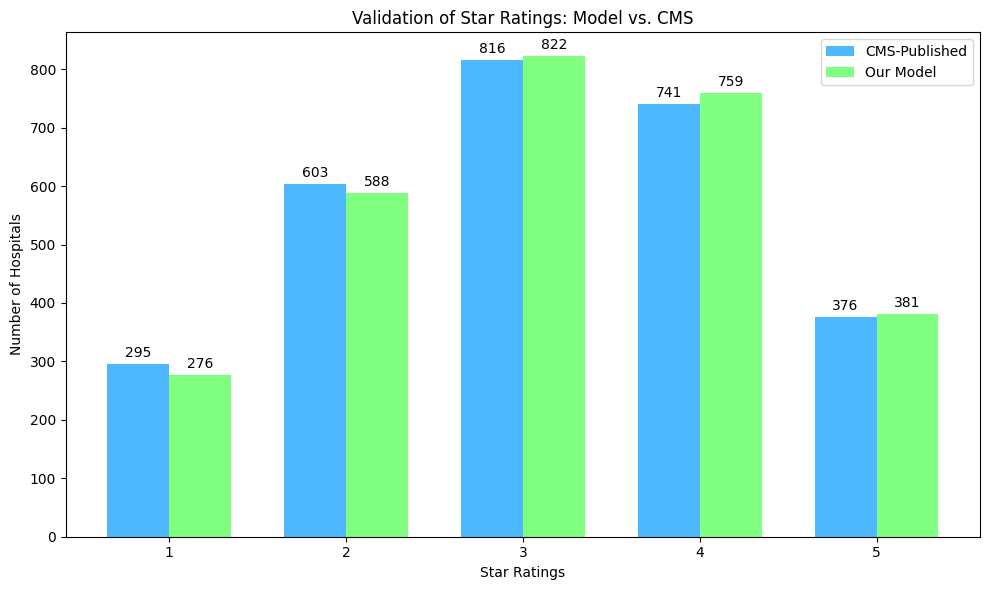

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Paths to files
hgi_clean_path = "/content/drive/My Drive/Capstone Project/Hospitals Data/Cleaned CSV/HGI_Clean.csv"
star_ratings_path = "/content/drive/My Drive/Capstone Project/SAS Star Data/Source Code/output/Step 2 Out/star_ratings_all_labeled.csv"

# Load the datasets
hgi_clean = pd.read_csv(hgi_clean_path)
star_ratings = pd.read_csv(star_ratings_path)

# Rename columns for consistency
hgi_clean.rename(columns={"Facility ID": "PROVIDER_ID", "Hospital overall rating": "HGI_Star"}, inplace=True)

# Standardize blanks in the HGI file
hgi_clean.replace("Not Available", pd.NA, inplace=True)

# Ensure both columns are numeric, treating blanks as NaN
hgi_clean["HGI_Star"] = pd.to_numeric(hgi_clean["HGI_Star"], errors="coerce")
star_ratings["star"] = pd.to_numeric(star_ratings["star"], errors="coerce")

# Count star ratings from CMS-published data and your model
cms_counts = star_ratings["star"].value_counts().sort_index()
model_counts = hgi_clean["HGI_Star"].value_counts().sort_index()

# Combine counts into a single DataFrame for alignment
star_counts = pd.DataFrame({
    "CMS-Published": cms_counts,
    "Our Model": model_counts
}).fillna(0).astype(int)

# Sort index (Star ratings) to ensure correct order
star_counts = star_counts.sort_index()

# Plot the data
x = np.arange(len(star_counts))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Define custom colors to match POC style
colors_cms = "#4db8ff"  # Light blue
colors_model = "#80ff80"  # Light green

bars1 = ax.bar(x - width/2, star_counts["CMS-Published"], width, label="CMS-Published", color=colors_cms)
bars2 = ax.bar(x + width/2, star_counts["Our Model"], width, label="Our Model", color=colors_model)

# Add labels, title, and legend
ax.set_xlabel("Star Ratings")
ax.set_ylabel("Number of Hospitals")
ax.set_title("Validation of Star Ratings: Model vs. CMS")
ax.set_xticks(x)
ax.set_xticklabels(star_counts.index.astype(int))
ax.legend()

# Annotate bar values
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()



# National Average

In [ ]:
import pandas as pd

# Read the star rating file into a DataFrame
data = pd.read_csv(f"{STEP_2_OUT_PATH}/Star_Ratings.csv")  # Ensure the file path is correct

# Helper function to calculate national average
def calculate_national_average(data, score_column, filter_column=None, filter_value=None):
    filtered_data = data
    if filter_column and filter_value is not None:
        filtered_data = data[data[filter_column] == filter_value]
    return filtered_data[score_column].mean()

# Helper function to calculate peer-group-specific averages
def calculate_peer_group_average(data, score_column, peer_group_column, filter_column=None, filter_value=None):
    filtered_data = data
    if filter_column and filter_value is not None:
        filtered_data = data[data[filter_column] == filter_value]
    grouped_avg = (
        filtered_data.groupby(peer_group_column)[score_column].mean().reset_index()
    )
    return grouped_avg

# Columns for national average group scores
measure_group_columns = [
    "Std_Outcomes_Mortality_score",
    "Std_Outcomes_Safety_score",
    "Std_Outcomes_Readmission_score",
    "Std_PatientExp_score",
    "Std_Process_score",
]

# Overall national average for summary score
summary_score_avg = calculate_national_average(
    data, score_column="summary_score", filter_column="report_indicator", filter_value=1
)

# Peer-group-specific averages for summary score
peer_group_avg = calculate_peer_group_average(
    data,
    score_column="summary_score",
    peer_group_column="Total_measure_group_cnt",
    filter_column="report_indicator",
    filter_value=1,
)

# Convert peer group averages to dictionary
peer_group_avg_dict = dict(zip(peer_group_avg["Total_measure_group_cnt"], peer_group_avg["summary_score"]))

# National averages for each group score
group_averages = {
    col: calculate_national_average(data, col, filter_column="report_indicator", filter_value=1)
    for col in measure_group_columns
}

# Combine results into a DataFrame
output = {
    "Summary_Score_Nat": [summary_score_avg],  # Overall national average
    "Summary_Score_Nat_peer3": [peer_group_avg_dict.get(3, float("nan"))],
    "Summary_Score_Nat_peer4": [peer_group_avg_dict.get(4, float("nan"))],
    "Summary_Score_Nat_peer5": [peer_group_avg_dict.get(5, float("nan"))],
}

# Add group averages
output.update({f"{col}_Nat": [avg] for col, avg in group_averages.items()})

# Create the final output DataFrame
output_df = pd.DataFrame(output)

# Save to CSV (optional)
output_df.to_csv(f"{STEP_2_OUT_PATH}/National_Averages_2024Jul.csv", index=False)

# Display the result
print(output_df)



   Summary_Score_Nat  Summary_Score_Nat_peer3  Summary_Score_Nat_peer4  \
0           -0.04289                -0.142824                 0.172541   

   Summary_Score_Nat_peer5  Std_Outcomes_Mortality_score_Nat  \
0                -0.082009                          0.109295   

   Std_Outcomes_Safety_score_Nat  Std_Outcomes_Readmission_score_Nat  \
0                       0.018251                           -0.095192   

   Std_PatientExp_score_Nat  Std_Process_score_Nat  
0                 -0.156733              -0.130919  
